<>:11: SyntaxWarning: invalid escape sequence '\Z'
<>:11: SyntaxWarning: invalid escape sequence '\Z'
C:\Users\Tiến Đạt\AppData\Local\Temp\ipykernel_16720\3707039398.py:11: SyntaxWarning: invalid escape sequence '\Z'
  df = pd.read_csv('d:\Zalo Received Files\mayhocsau\jena_climate_2009_2016.csv')


Shape của dataset gốc: (420551, 14)

Info của dataset:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 420551 entries, 2009-01-01 00:10:00 to 2017-01-01 00:00:00
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   p (mbar)         420551 non-null  float64
 1   T (degC)         420551 non-null  float64
 2   Tpot (K)         420551 non-null  float64
 3   Tdew (degC)      420551 non-null  float64
 4   rh (%)           420551 non-null  float64
 5   VPmax (mbar)     420551 non-null  float64
 6   VPact (mbar)     420551 non-null  float64
 7   VPdef (mbar)     420551 non-null  float64
 8   sh (g/kg)        420551 non-null  float64
 9   H2OC (mmol/mol)  420551 non-null  float64
 10  rho (g/m**3)     420551 non-null  float64
 11  wv (m/s)         420551 non-null  float64
 12  max. wv (m/s)    420551 non-null  float64
 13  wd (deg)         420551 non-null  float64
dtypes: float64(14)
memory usage: 48.1 MB
None



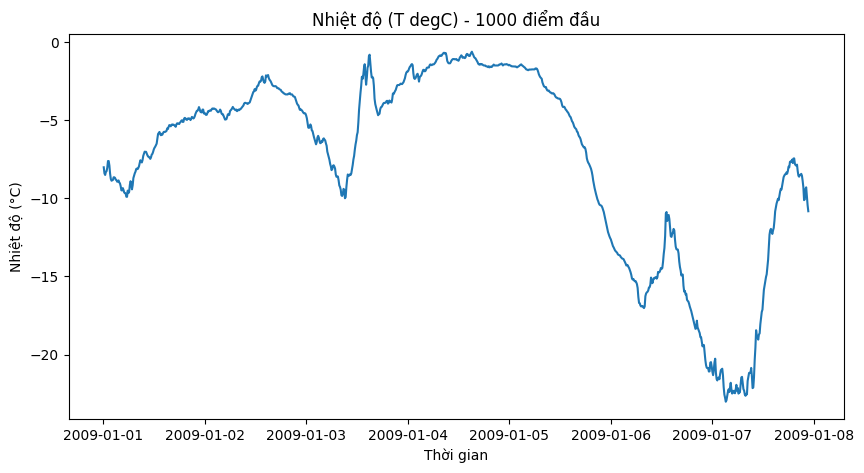

Sau khi xử lý NA, số lượng NA còn lại: 0
Bounds cho outlier (T degC): [-14.81, 33.64]
Shape sau khi loại outlier: (419023, 14)
Shape sau khi subsample (mỗi giờ): (69838, 14)
Shape của X (inputs): (69743, 72, 14)
Shape của y (outputs): (69743, 24)
Train size: 48820, Val size: 13948, Test size: 6975
Dữ liệu đã được lưu vào 'processed_data.npz'


In [1]:
# data_preprocessing.ipynb

# Cell 1: Import thư viện
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Cell 2: Load và khám phá dữ liệu
# Load dataset từ path đã cho
df = pd.read_csv('d:\Zalo Received Files\mayhocsau\jena_climate_2009_2016.csv')

# Chuyển cột 'Date Time' thành datetime và set làm index
df['Date Time'] = pd.to_datetime(df['Date Time'], format='%d.%m.%Y %H:%M:%S')
df.set_index('Date Time', inplace=True)

# Khám phá dữ liệu
print("Shape của dataset gốc:", df.shape)
print("\nInfo của dataset:")
print(df.info())
print("\nDescribe của dataset:")
print(df.describe())
print("\nSố lượng NA trong mỗi cột:")
print(df.isnull().sum())

# Visualize một cột mẫu (nhiệt độ) để kiểm tra
plt.figure(figsize=(10, 5))
plt.plot(df.index[:1000], df['T (degC)'][:1000])  # Plot 1000 điểm đầu tiên
plt.title('Nhiệt độ (T degC) - 1000 điểm đầu')
plt.xlabel('Thời gian')
plt.ylabel('Nhiệt độ (°C)')
plt.show()

# Cell 3: Làm sạch dữ liệu
# Xử lý NA: Fill bằng mean cho các cột số (nếu có NA)
# Kiểm tra phiên bản pandas để tránh lỗi (numeric_only=True)
try:
    df.fillna(df.mean(numeric_only=True), inplace=True)
except TypeError:
    # Nếu phiên bản cũ, dùng cách khác
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())
print("Sau khi xử lý NA, số lượng NA còn lại:", df.isnull().sum().sum())

# Loại outlier cho cột 'T (degC)' sử dụng IQR
Q1 = df['T (degC)'].quantile(0.25)
Q3 = df['T (degC)'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print(f"Bounds cho outlier (T degC): [{lower_bound:.2f}, {upper_bound:.2f}]")
df = df[(df['T (degC)'] >= lower_bound) & (df['T (degC)'] <= upper_bound)]
print("Shape sau khi loại outlier:", df.shape)

# Cell 4: Subsample dữ liệu để giảm memory (từ mỗi 10 phút xuống mỗi giờ)
df = df.iloc[::6]  # Mỗi 6 hàng (1 giờ)
print("Shape sau khi subsample (mỗi giờ):", df.shape)  # ~70k hàng

# Cell 5: Tạo cửa sổ thời gian (time windows) - Giảm kích thước để tránh MemoryError
# Giả sử dự đoán 'T (degC)' (nhiệt độ) từ 3 ngày quá khứ (432 timesteps) để dự đoán 1 ngày tiếp theo (144 timesteps)
# Dataset mỗi giờ, nên 24 timesteps/ngày
input_steps = 3 * 24  # 72 (giảm từ 720)
output_steps = 1 * 24  # 24 (giảm từ 432)

# Hàm tạo sequences (dùng float32 để giảm memory)
def create_sequences(data, input_steps, output_steps):
    X, y = [], []
    for i in range(len(data) - input_steps - output_steps + 1):
        X.append(data[i:i + input_steps])  # Input: 3 ngày quá khứ
        y.append(data[i + input_steps:i + input_steps + output_steps, 0])  # Output: 1 ngày tiếp theo của cột đầu (T degC)
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)  # Dùng float32

# Chuẩn hóa dữ liệu trước khi tạo sequences (sử dụng MinMaxScaler)
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df.values).astype(np.float32)  # Scale và chuyển float32

# Tạo sequences
X, y = create_sequences(scaled_data, input_steps, output_steps)
print("Shape của X (inputs):", X.shape)  # ~ (samples, 72, 14)
print("Shape của y (outputs):", y.shape)  # ~ (samples, 24)
# Ước tính memory: X ~ (67k, 72, 14) * 4 bytes ~ 0.13 GiB; y ~ (67k, 24) * 4 ~ 0.006 GiB

# Cell 6: Tách tập train/val/test (theo thời gian, không shuffle)
total_samples = len(X)
train_size = int(0.7 * total_samples)
val_size = int(0.2 * total_samples)
test_size = total_samples - train_size - val_size

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]

print(f"Train size: {len(X_train)}, Val size: {len(X_val)}, Test size: {len(X_test)}")

# Cell 7: Lưu dữ liệu đã xử lý
# Lưu vào file .npz (chứa arrays và scaler attributes để inverse transform)
np.savez('processed_data.npz', 
         X_train=X_train, y_train=y_train, 
         X_val=X_val, y_val=y_val, 
         X_test=X_test, y_test=y_test,
         scaler_data_min=scaler.data_min_,  # Để tái tạo scaler
         scaler_data_max=scaler.data_max_,
         scaler_data_range=scaler.data_range_)

print("Dữ liệu đã được lưu vào 'processed_data.npz'")

# Tùy chọn: Nếu cần lưu CSV (chỉ cho df đã clean, không phải sequences)
# df.to_csv('cleaned_data.csv', index=True)
# print("Dữ liệu đã clean cũng được lưu vào 'cleaned_data.csv'")

#Cell 8: Hướng dẫn load và tái tạo scaler (nếu cần inverse transform)
#Để load dữ liệu và tái tạo scaler:
data = np.load('processed_data.npz')
X_train = data['X_train']
scaler = MinMaxScaler()
scaler.data_min_ = data['scaler_data_min']
scaler.data_max_ = data['scaler_data_max']
scaler.data_range_ = data['scaler_data_range']
# # Bây giờ có thể dùng scaler.inverse_transform(X_train) để inverse